In [3]:
from typing import List, Tuple, Any

In [4]:
import requests
import json

In [5]:
query : dict[str, Any] = {
    "query" : {
        "type" : "group",
        "logical_operator" : "and",
        "nodes" : [
            {
                "type" : "terminal",
                "service" : "text",
                "parameters" : {
                    "attribute" : "rcsb_entry_info.resolution_combined",
                    "operator" : "range",
                    "value" : {
                        "from" : 1,
                        "to" : 3,
                        "include_lower" : True,
                        "include_upper" : True
                    }
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "rcsb_entity_source_organism.taxonomy_lineage.name",
                    "operator": "exact_match",
                    "value": "Homo sapiens"
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "rcsb_entry_info.selected_polymer_entity_types",
                    "operator": "exact_match",
                    "value": "Protein (only)"
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "rcsb_struct_symmetry.type",
                    "operator": "exact_match",
                    "value": "Asymmetric"
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "entity_poly.rcsb_sample_sequence_length",
                    "operator": "exists",
                }
            }
        ],
        "label" : "text"
    },
    "return_type": "entry",
    "request_options": {
        "paginate": {
            "rows": 10000,
            "start": 0
        },
        "results_content_type": [
            "experimental"
        ],
        "sort": [
            {
                "sort_by": "score",
                "direction": "desc"
            }
        ],
        "scoring_strategy": "combined"
    }
}

In [6]:
request_url = "https://search.rcsb.org/rcsbsearch/v2/query"

In [7]:
first_req = requests.get(request_url, params = {"json": json.dumps(query, separators=(',', ':'))})

In [8]:
identifiers : List[str] = []
for entry in first_req.json()["result_set"]:
    identifiers.append(entry["identifier"])

In [9]:
for i in range(10000, first_req.json()["total_count"], 10000):
    query["request_options"]["paginate"]["start"] = i
    req = requests.get(request_url, params = {"json": json.dumps(query, separators=(',', ':'))})
    for entry in req.json()["result_set"]:
        identifiers.append(entry["identifier"])

In [10]:
from Bio.PDB import PDBList, PDBParser
from Bio.PDB.DSSP import DSSP

In [11]:
pdb_list = PDBList(server="https://files.wwpdb.org/")
parser = PDBParser()

In [13]:
pdb_list.download_pdb_files(identifiers, pdir="pdb_files", file_format="pdb", overwrite=False)

Structure exists: 'pdb_files/pdb12ca.ent' 
Structure exists: 'pdb_files/pdb133l.ent' 
Structure exists: 'pdb_files/pdb1a07.ent' 
Structure exists: 'pdb_files/pdb1a08.ent' 
Structure exists: 'pdb_files/pdb134l.ent' 
Structure exists: 'pdb_files/pdb1a1a.ent' 
Structure exists: 'pdb_files/pdb1a1c.ent' 
Structure exists: 'pdb_files/pdb1a1e.ent' 
Structure exists: 'pdb_files/pdb1a1b.ent' 
Structure exists: 'pdb_files/pdb1a1m.ent' 
Structure exists: 'pdb_files/pdb1a1n.ent' 
Structure exists: 'pdb_files/pdb1a22.ent' 
Structure exists: 'pdb_files/pdb1a09.ent' 
Structure exists: 'pdb_files/pdb1a28.ent' 
Structure exists: 'pdb_files/pdb1a1o.ent' 
Structure exists: 'pdb_files/pdb1a2c.ent' 
Structure exists: 'pdb_files/pdb1a3b.ent' 
Structure exists: 'pdb_files/pdb1a3e.ent' 
Structure exists: 'pdb_files/pdb1a2b.ent' 
Structure exists: 'pdb_files/pdb1a3s.ent' 
Structure exists: 'pdb_files/pdb1a42.ent' 
Structure exists: 'pdb_files/pdb1a46.ent' 
Structure exists: 'pdb_files/pdb1a4v.ent' 
Structure e

In [14]:
import os
from multiprocess import Pool, cpu_count

In [15]:
def get_seq_and_ss(id : str) -> Tuple[str, str] | None:
    try:
        file_name = f"pdb_files/pdb{id.lower()}.ent"
        if not os.path.exists(file_name):
            return None
        structure = parser.get_structure(id, file_name)
        model = structure[0]
        dssp = DSSP(model, file_name, dssp="mkdssp", file_type="PDB")
        seq = ""
        ss = ""
        for i in range(len(dssp)):
            a_key = list(dssp.keys())[i]
            seq += dssp[a_key][1]
            ss += dssp[a_key][2]
        
        return (seq, ss)
    except Exception as e:
        return None


In [16]:
data : List[Tuple[str, str, str]] = []
failed_identifiers : List[str] = []

In [ ]:
max_pool = cpu_count() - 1

with Pool(max_pool) as p:
    results = p.map(get_seq_and_ss, identifiers)

In [37]:
for i in range(len(identifiers)):
    if results[i] is None or results[i][0] == "" or results[i][1] == "":
        failed_identifiers.append(identifiers[i])
    else:
        data.append((identifiers[i], results[i][0], results[i][1]))

In [38]:
with open("data.csv", "w") as f:
    f.write("identifier,sequence,secondary_structure\n")
    for identifier, sequence, secondary_structure in data:
        f.write(f"{identifier},{sequence},{secondary_structure}\n")

In [ ]:
# Read data back once calculations are done to avoid re-running the above code

data : List[Tuple[str, str, str]] = []
with open("data.csv", "r") as f:
    f.readline()
    for line in f:
        identifier, sequence, secondary_structure = line.strip().split(",")
        data.append((identifier, sequence, secondary_structure))

(array([ 6709., 15733.,  6504.,  3077.,  1861.,  1452.,   950.,   403.,
          252.,   191.]),
 array([   4. ,  208.2,  412.4,  616.6,  820.8, 1025. , 1229.2, 1433.4,
        1637.6, 1841.8, 2046. ]),
 <BarContainer object of 10 artists>)

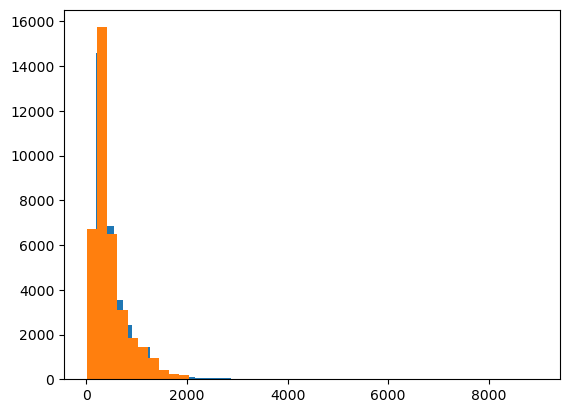

In [25]:
# Histogram of sequence lengths
import matplotlib.pyplot as plt
import numpy as np

sequence_lengths = [len(sequence) for _, sequence, _ in data]
plt.hist(sequence_lengths, bins=50)

filtered_data_le_2048 = [(identifier, sequence, secondary_structure) for identifier, sequence, secondary_structure in data if len(sequence) <= 2048]
filtered_seq_lens = [len(sequence) for _, sequence, _ in filtered_data_le_2048]
plt.hist(filtered_seq_lens)

In [26]:
with open("data_filtered_le_2048.csv", "w") as f:
    f.write("identifier,sequence,secondary_structure\n")
    for identifier, sequence, secondary_structure in filtered_data_le_2048:
        f.write(f"{identifier},{sequence},{secondary_structure}\n")